# Importing libraries

# Python Libraries Description

## Overview
This markdown describes Python libraries commonly used in Jupyter Notebooks for data analysis, visualization, and machine learning.

## Library Descriptions
- **numpy**: Handles numerical computations with arrays and matrices.
- **pandas**: Manages and analyzes data using DataFrames.
- **matplotlib.pyplot**: Generates plots and visualizations.
- **seaborn**: Creates enhanced statistical visualizations.
- **tensorflow**: Supports building and training machine learning models.

## Purpose
These libraries enable efficient data processing, visualization, and machine learning model development in Jupyter Notebooks, using standard aliases for concise coding.

In [9]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Loading Data in Jupyter Notebook

## Overview
This Python code loads three CSV files into pandas DataFrames for data analysis in a Jupyter Notebook.

## Code Description
- **`hotels = pd.read_csv("C:/Users/abdel/ACL/archive/hotels.csv")`**: Loads hotel data from a CSV file into a DataFrame named `hotels`.
- **`reviews = pd.read_csv("C:/Users/abdel/ACL/archive/reviews.csv")`**: Loads review data from a CSV file into a DataFrame named `reviews`.
- **`users = pd.read_csv("C:/Users/abdel/ACL/archive/users.csv")`**: Loads user data from a CSV file into a DataFrame named `users`.

## Purpose
This code imports datasets into pandas DataFrames for further analysis, manipulation, or visualization in a Jupyter Notebook, assuming the files exist at the specified file paths.

In [10]:
hotels=pd.read_csv("C:\\Users\\abdel\\ACL\\archive\\hotels.csv")
reviews=pd.read_csv("C:\\Users\\abdel\\ACL\\archive\\reviews.csv")
users=pd.read_csv("C:\\Users\\abdel\\ACL\\archive\\users.csv")

### 🔍 Data Quality Check

This cell checks for duplicates and missing values in the **Hotels**, **Reviews**, and **Users** datasets using `duplicated()` and `isnull().sum()`.  
It was found that there are **no duplicate records** and **no missing values** in any of the datasets.


In [11]:
print(f"Hotels duplicates: {hotels.duplicated().sum()}")
print(f"Reviews duplicates: {reviews.duplicated().sum()}")
print(f"Users duplicates: {users.duplicated().sum()}")
print("--------------------------------")
print(f"Hotels nuls: {hotels.isnull().sum()}")
print("--------------------------------")
print(f"Reviews nuls: {reviews.isnull().sum()}")
print("--------------------------------")
print(f"Users nuls: {users.isnull().sum()}")

Hotels duplicates: 0
Reviews duplicates: 0
Users duplicates: 0
--------------------------------
Hotels nuls: hotel_id                0
hotel_name              0
city                    0
country                 0
star_rating             0
lat                     0
lon                     0
cleanliness_base        0
comfort_base            0
facilities_base         0
location_base           0
staff_base              0
value_for_money_base    0
dtype: int64
--------------------------------
Reviews nuls: review_id                0
user_id                  0
hotel_id                 0
review_date              0
score_overall            0
score_cleanliness        0
score_comfort            0
score_facilities         0
score_location           0
score_staff              0
score_value_for_money    0
review_text              0
dtype: int64
--------------------------------
Users nuls: user_id           0
user_gender       0
country           0
age_group         0
traveller_type    0
join_date  

### 🧾 Dataset Overview

This cell displays the structure and summary information of the **Reviews**, **Hotels**, and **Users** datasets using `info()`.  
It shows the number of entries, column names, data types, and confirms that there are **no missing values** in any dataset.


In [12]:
reviews.info()
print("--------------------------------")   
hotels.info()
print("--------------------------------")
users.info()
print("--------------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              50000 non-null  int64  
 1   user_id                50000 non-null  int64  
 2   hotel_id               50000 non-null  int64  
 3   review_date            50000 non-null  object 
 4   score_overall          50000 non-null  float64
 5   score_cleanliness      50000 non-null  float64
 6   score_comfort          50000 non-null  float64
 7   score_facilities       50000 non-null  float64
 8   score_location         50000 non-null  float64
 9   score_staff            50000 non-null  float64
 10  score_value_for_money  50000 non-null  float64
 11  review_text            50000 non-null  object 
dtypes: float64(7), int64(3), object(2)
memory usage: 4.6+ MB
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 2

This code merges the reviews, hotels, and users datasets into one DataFrame (df) by performing left joins on the hotel_id and user_id columns to combine review, hotel, and user information.

# Merging DataFrames

## Overview
Merges pandas DataFrames (`reviews`, `hotels`, `users`) for analysis in Jupyter Notebook.

## Description
- **`review_hotel_df = reviews.merge(hotels, on='hotel_id', how='left')`**: Merges `reviews` with `hotels` on `hotel_id` using left join.
- **`df = review_hotel_df.merge(users, on='user_id', how='left')`**: Merges `review_hotel_df` with `users` on `user_id` using left join.

## Purpose
Combines review, hotel, and user data into one DataFrame for integrated analysis.

In [13]:
review_hotel_df=reviews.merge(hotels,on='hotel_id',how='left')
df=review_hotel_df.merge(users,on='user_id',how='left')

# Renaming Columns

## Overview
Renames columns in a pandas DataFrame for clarity in Jupyter Notebook.

## Description
- **`df.rename(columns={"country_x":"hotel_country","country_y":"user_country"}, inplace=True)`**: Renames `country_x` to `hotel_country` and `country_y` to `user_country` in `df` directly.

## Purpose
Improves readability by clarifying column names in the merged dataset.

In [14]:
df.rename(columns={"country_x":"hotel_country","country_y":"user_country"},inplace=True)

# Country Grouping in DataFrame

## Overview
Assigns country groups to users based on their country and displays selected columns.

## Description
- **`groups = {...}`**: Defines a dictionary mapping regions to lists of countries (e.g., North_America: United States, Canada).
- **`df["country_group"] = df["user_country"].apply(...)`**: Creates a `country_group` column by mapping `user_country` to a region from `groups`, defaulting to "Other" if not found.
- **`df[["hotel_country","user_country","country_group"]]`**: Selects `hotel_country`, `user_country`, and `country_group` columns for display.

## Purpose
Categorizes users by geographic region and shows relevant country data to fill country_group column.

In [15]:
groups={'North_America':['United States','Canada'],
        'Western_Europe':['Germany','France','United Kingdom','Netherlands','Spain','Italy'],
        'Eastern_Europe':['Russia'],
        'East_Asia':['China','Japan','South Korea'],
        'Southeast_Asia':['Thailand','Singapore'],
        'Middle_East':['United Arab Emirates','Turkey'],
        'Africa':['Egypt','Nigeria','South Africa'],
        'Oceania':['Australia','New Zealand'],
        'South_America':['Brazil','Argentina'],
        'South_Asia':['India'],
        'North_America_Mexico':['Mexico']}

df["country_group"]=df["user_country"].apply(lambda x: next((key for key, value in groups.items() if x in value), "Other"))

df[["hotel_country","user_country","country_group"]]

,hotel_country,user_country,country_group
0,United States,New Zealand,Oceania
1,Japan,United Kingdom,Western_Europe
2,Egypt,Spain,Western_Europe
3,Spain,United Kingdom,Western_Europe
4,Russia,Australia,Oceania
...,...,...,...
49995,Nigeria,Mexico,North_America_Mexico
49996,Brazil,New Zealand,Oceania
49997,Singapore,Russia,Eastern_Europe
49998,Turkey,United Kingdom,Western_Europe


# Data-Engineering Question 1 

## Overview
Calculates the best city for each traveller type based on reviews.

## Description
- **`city_scores = df.groupby(['traveller_type', 'city'])['score_overall'].mean().reset_index().sort_values(...)`**: Groups data by `traveller_type` and `city`, computes mean `score_overall`, resets index, and sorts by `traveller_type` (ascending) and `score_overall` (descending).
- **`best_cities = city_scores.groupby('traveller_type').head(1)`**: Selects the top city (highest score) for each `traveller_type`.


In [16]:
city_scores = df.groupby(['traveller_type', 'city'])['score_overall'].mean().reset_index().sort_values(['traveller_type', 'score_overall'], ascending=[True,False])

best_cities = city_scores.groupby('traveller_type').head(1)

# display(city_scores)


C:\Users\abdel\AppData\Local\Temp\ipykernel_3692\530573463.py:35: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\abdel\fire_env_tf\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


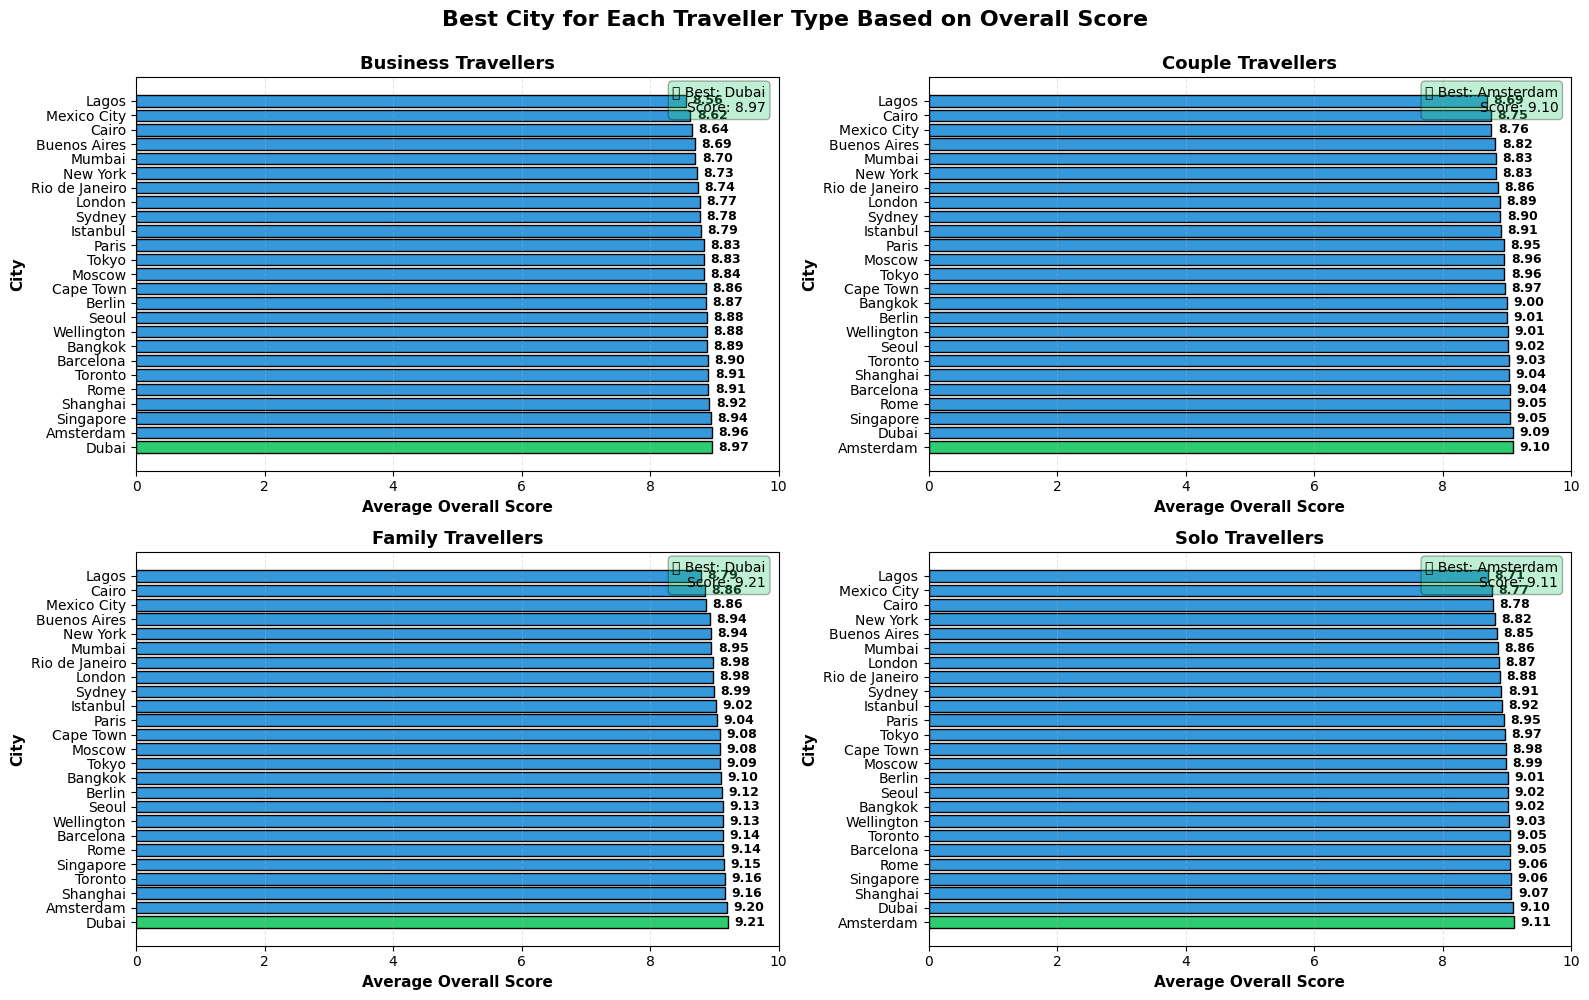

In [17]:

# OPTION 1: Grouped Bar Chart (One subplot per traveller type) - RECOMMENDED
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

traveller_types = city_scores['traveller_type'].unique()

for idx, traveller in enumerate(traveller_types):
    # Filter data for this traveller type
    data = city_scores[city_scores['traveller_type'] == traveller]
    best_city = best_cities[best_cities['traveller_type'] == traveller]['city'].values[0]
    
    # Create colors (highlight best city in green)
    colors = ['#2ECC71' if city == best_city else '#3498DB' for city in data['city']]
    
    # Plot horizontal bar chart
    axes[idx].barh(data['city'], data['score_overall'], color=colors, edgecolor='black', linewidth=1)
    axes[idx].set_xlabel('Average Overall Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('City', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{traveller} Travellers', fontsize=13, fontweight='bold')
    axes[idx].set_xlim(0, 10)
    axes[idx].grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add score labels on bars
    for i, (city, score) in enumerate(zip(data['city'], data['score_overall'])):
        axes[idx].text(score + 0.1, i, f'{score:.2f}', va='center', fontsize=9, fontweight='bold')
    
    # Add best city annotation
    best_score = best_cities[best_cities['traveller_type'] == traveller]['score_overall'].values[0]
    axes[idx].text(0.98, 0.98, f'🏆 Best: {best_city}\nScore: {best_score:.2f}',
                  transform=axes[idx].transAxes, fontsize=10, ha='right', va='top',
                  bbox=dict(boxstyle='round', facecolor='#2ECC71', alpha=0.3, edgecolor='black'))

plt.suptitle('Best City for Each Traveller Type Based on Overall Score', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

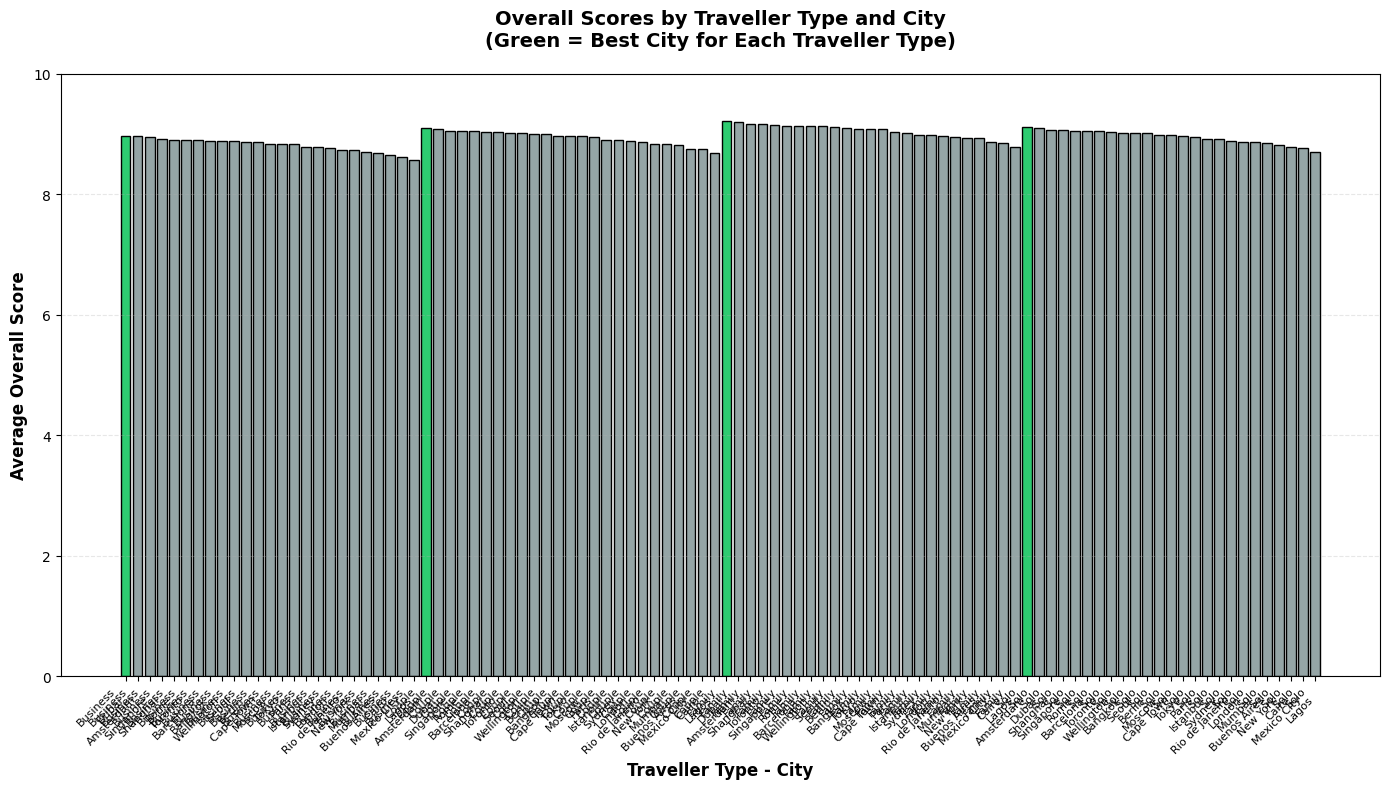

In [18]:
plt.figure(figsize=(14, 8))

# Create position for bars
traveller_list = []
city_list = []
score_list = []
color_list = []

for traveller in traveller_types:
    data = city_scores[city_scores['traveller_type'] == traveller]
    best_city = best_cities[best_cities['traveller_type'] == traveller]['city'].values[0]
    
    for _, row in data.iterrows():
        traveller_list.append(traveller)
        city_list.append(row['city'])
        score_list.append(row['score_overall'])
        color_list.append('#2ECC71' if row['city'] == best_city else '#95A5A6')

# Create grouped bar chart
x_labels = [f"{t}\n{c}" for t, c in zip(traveller_list, city_list)]
x_pos = range(len(x_labels))

plt.bar(x_pos, score_list, color=color_list, edgecolor='black', linewidth=1)
plt.xlabel('Traveller Type - City', fontsize=12, fontweight='bold')
plt.ylabel('Average Overall Score', fontsize=12, fontweight='bold')
plt.title('Overall Scores by Traveller Type and City\n(Green = Best City for Each Traveller Type)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(x_pos, x_labels, rotation=45, ha='right', fontsize=8)
plt.ylim(0, 10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


# The Plot of question 1
 ### 📊 Best City per Traveller Type

This bar chart compares the **average overall score** for different traveller types, highlighting the **best-rated city** for each group.  
Each bar represents a traveller type, labeled with the city that received the highest score and its exact value.  
The plot shows how preferences differ among traveller types based on their overall ratings.


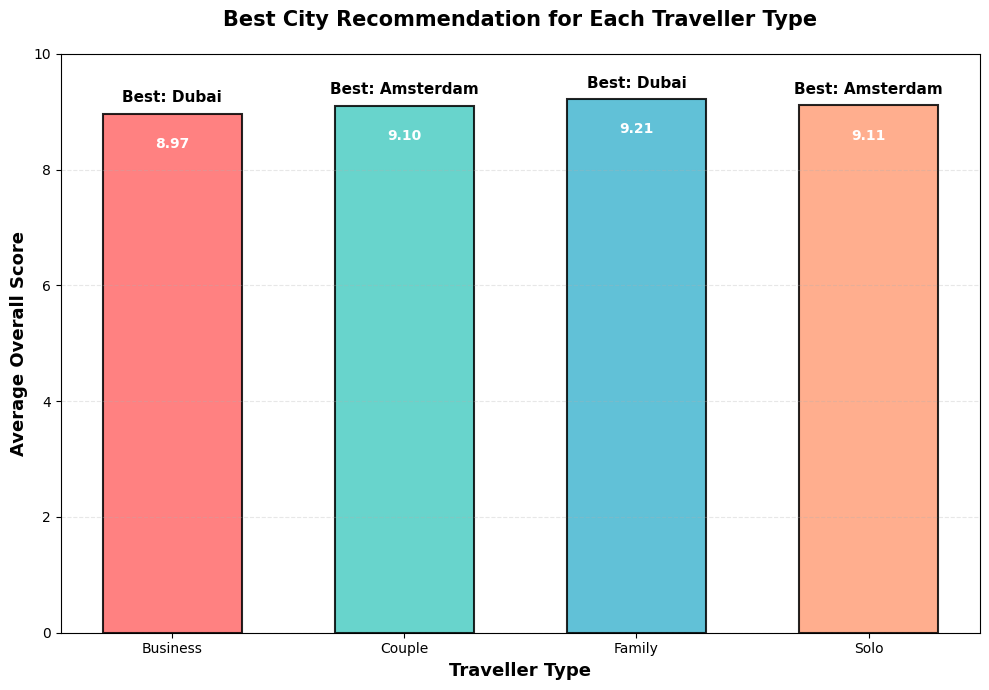

In [19]:
plt.figure(figsize=(10, 7))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = plt.bar(best_cities['traveller_type'], 
               best_cities['score_overall'], 
               color=colors, 
               edgecolor='black', 
               linewidth=1.5, 
               alpha=0.85,
               width=0.6)

plt.xlabel('Traveller Type', fontsize=13, fontweight='bold')
plt.ylabel('Average Overall Score', fontsize=13, fontweight='bold')
plt.title('Best City Recommendation for Each Traveller Type', 
          fontsize=15, fontweight='bold', pad=20)
plt.ylim(0, 10)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add city names and scores on top of each bar (replace 🏆 with text)
for i, (traveller, city, score) in enumerate(zip(best_cities['traveller_type'], 
                                                   best_cities['city'], 
                                                   best_cities['score_overall'])):
    plt.text(i, score + 0.15, f'Best: {city}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(i, score - 0.4, f'{score:.2f}', 
             ha='center', va='top', fontsize=10, fontweight='bold', color='white')

# plt.xticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()



# Question 2

### 🌍 Top Countries by Value-for-Money Score

This code calculates the **average value-for-money score** for each country within every **age group**.  
It then sorts the results and extracts the **top 3 countries** per age group with the highest average scores.


In [20]:
df = pd.get_dummies(df, columns=['traveller_type'], drop_first=True)
df = pd.get_dummies(df, columns=['city'], drop_first=True)
df = pd.get_dummies(df, columns=['user_gender'], drop_first=True)

age_order = {
    '18-24': 1,
    '25-34': 2,
    '35-44': 3,
    '45-54': 4,
    '55+': 5
}

df['age'] = df['age_group'].map(age_order)
df.drop(columns=['age_group'], inplace=True)

### 🧹 Feature Selection and Cleanup

This cell removes unnecessary or non-numerical columns (like IDs, text, and location data) that are not needed for analysis or modeling.  
The resulting `final_df` contains only the relevant features for further processing.


In [21]:

from typing import final


columns_to_drop = [
    'review_id',         
    'user_id',           
    'hotel_id',          
    'review_date',      
    'join_date',          
    'user_country',     
    'review_text',       
    'hotel_name',        
    'hotel_country',      
    'lat',                
    'lon'  
]
final_df=df.drop(columns=columns_to_drop)

# final_df.to_csv('final_dataset.csv', index=False)   
final_df.head()


,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,star_rating,cleanliness_base,comfort_base,...,city_Seoul,city_Shanghai,city_Singapore,city_Sydney,city_Tokyo,city_Toronto,city_Wellington,user_gender_Male,user_gender_Other,age
0,8.7,8.6,8.7,8.5,9.0,8.8,8.7,5,9.1,8.8,...,False,False,False,False,False,False,False,False,False,2
1,9.1,10.0,9.1,9.0,8.6,9.4,8.6,5,9.6,9.0,...,False,False,False,False,True,False,False,False,False,3
2,8.8,9.7,8.8,8.3,8.7,8.1,8.6,5,8.8,8.7,...,False,False,False,False,False,False,False,False,False,5
3,8.9,9.0,8.8,8.5,9.6,9.1,8.3,5,9.2,9.1,...,False,False,False,False,False,False,False,False,False,3
4,9.1,8.9,9.5,9.3,8.3,9.4,8.9,5,9.1,9.3,...,False,False,False,False,False,False,False,True,False,4


# Checking for null values 

after checking the data in the table there was no null values

In [22]:
final_df.isnull().sum()

score_overall            0
score_cleanliness        0
score_comfort            0
score_facilities         0
score_location           0
score_staff              0
score_value_for_money    0
star_rating              0
cleanliness_base         0
comfort_base             0
facilities_base          0
location_base            0
staff_base               0
value_for_money_base     0
country_group            0
traveller_type_Couple    0
traveller_type_Family    0
traveller_type_Solo      0
city_Bangkok             0
city_Barcelona           0
city_Berlin              0
city_Buenos Aires        0
city_Cairo               0
city_Cape Town           0
city_Dubai               0
city_Istanbul            0
city_Lagos               0
city_London              0
city_Mexico City         0
city_Moscow              0
city_Mumbai              0
city_New York            0
city_Paris               0
city_Rio de Janeiro      0
city_Rome                0
city_Seoul               0
city_Shanghai            0
c

In [23]:
final_df.rename(columns={"age_encoded":"age","ci":"user_country"},inplace=True)

In [24]:
final_df.to_csv('final_dataset.csv', index=False)

final_df is the cleaned dataset 

In [25]:
X = final_df[['score_overall','score_cleanliness','score_comfort','score_facilities','score_location','score_staff','score_value_for_money','star_rating','cleanliness_base','comfort_base','facilities_base','location_base','staff_base','value_for_money_base','traveller_type_Couple','traveller_type_Family','traveller_type_Solo','city_Bangkok','city_Barcelona','city_Berlin','city_Buenos Aires','city_Cairo','city_Cape Town','city_Dubai','city_Istanbul','city_Lagos','city_London','city_Mexico City','city_Moscow','city_Mumbai','city_New York','city_Paris','city_Rio de Janeiro','city_Rome','city_Seoul','city_Shanghai','city_Singapore','city_Sydney','city_Tokyo','city_Toronto','city_Wellington','user_gender_Male','user_gender_Other','age' ]] 
y = final_df['country_group']

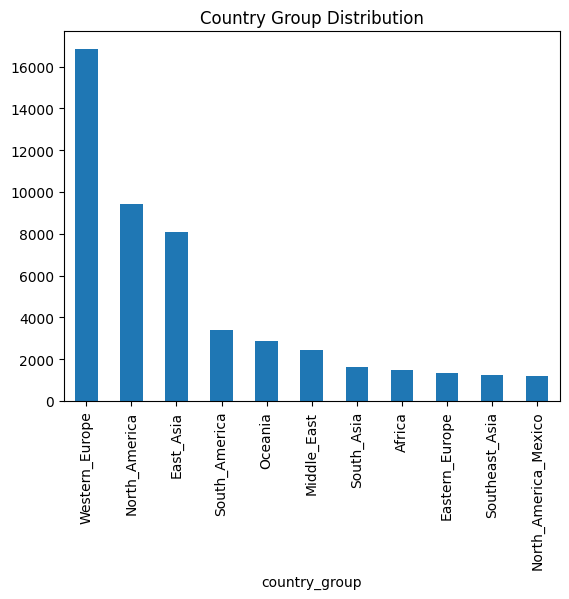

In [26]:
y.value_counts().plot(kind='bar', title='Country Group Distribution')
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
log_model = LogisticRegression(
    max_iter=1000,
)

In [29]:
log_model.fit(X_train,y_train)

c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [30]:
y_pred = log_model.predict(X_test)

print("=== Logistic Regression Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nDetailed Report:\n", classification_report(y_test, y_pred))

c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


=== Logistic Regression Evaluation ===
Accuracy: 0.3393
Precision: 0.11512449
Recall: 0.3393
F1 Score: 0.17191740461435076

Detailed Report:
                       precision    recall  f1-score   support

              Africa       0.00      0.00      0.00       305
           East_Asia       0.00      0.00      0.00      1618
      Eastern_Europe       0.00      0.00      0.00       264
         Middle_East       0.00      0.00      0.00       469
       North_America       0.00      0.00      0.00      1935
North_America_Mexico       0.00      0.00      0.00       243
             Oceania       0.00      0.00      0.00       548
       South_America       0.00      0.00      0.00       631
          South_Asia       0.00      0.00      0.00       335
      Southeast_Asia       0.00      0.00      0.00       259
      Western_Europe       0.34      1.00      0.51      3393

            accuracy                           0.34     10000
           macro avg       0.03      0.09      0.0

c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   score_overall          50000 non-null  float64
 1   score_cleanliness      50000 non-null  float64
 2   score_comfort          50000 non-null  float64
 3   score_facilities       50000 non-null  float64
 4   score_location         50000 non-null  float64
 5   score_staff            50000 non-null  float64
 6   score_value_for_money  50000 non-null  float64
 7   star_rating            50000 non-null  int64  
 8   cleanliness_base       50000 non-null  float64
 9   comfort_base           50000 non-null  float64
 10  facilities_base        50000 non-null  float64
 11  location_base          50000 non-null  float64
 12  staff_base             50000 non-null  float64
 13  value_for_money_base   50000 non-null  float64
 14  country_group          50000 non-null  object 
 15  tr

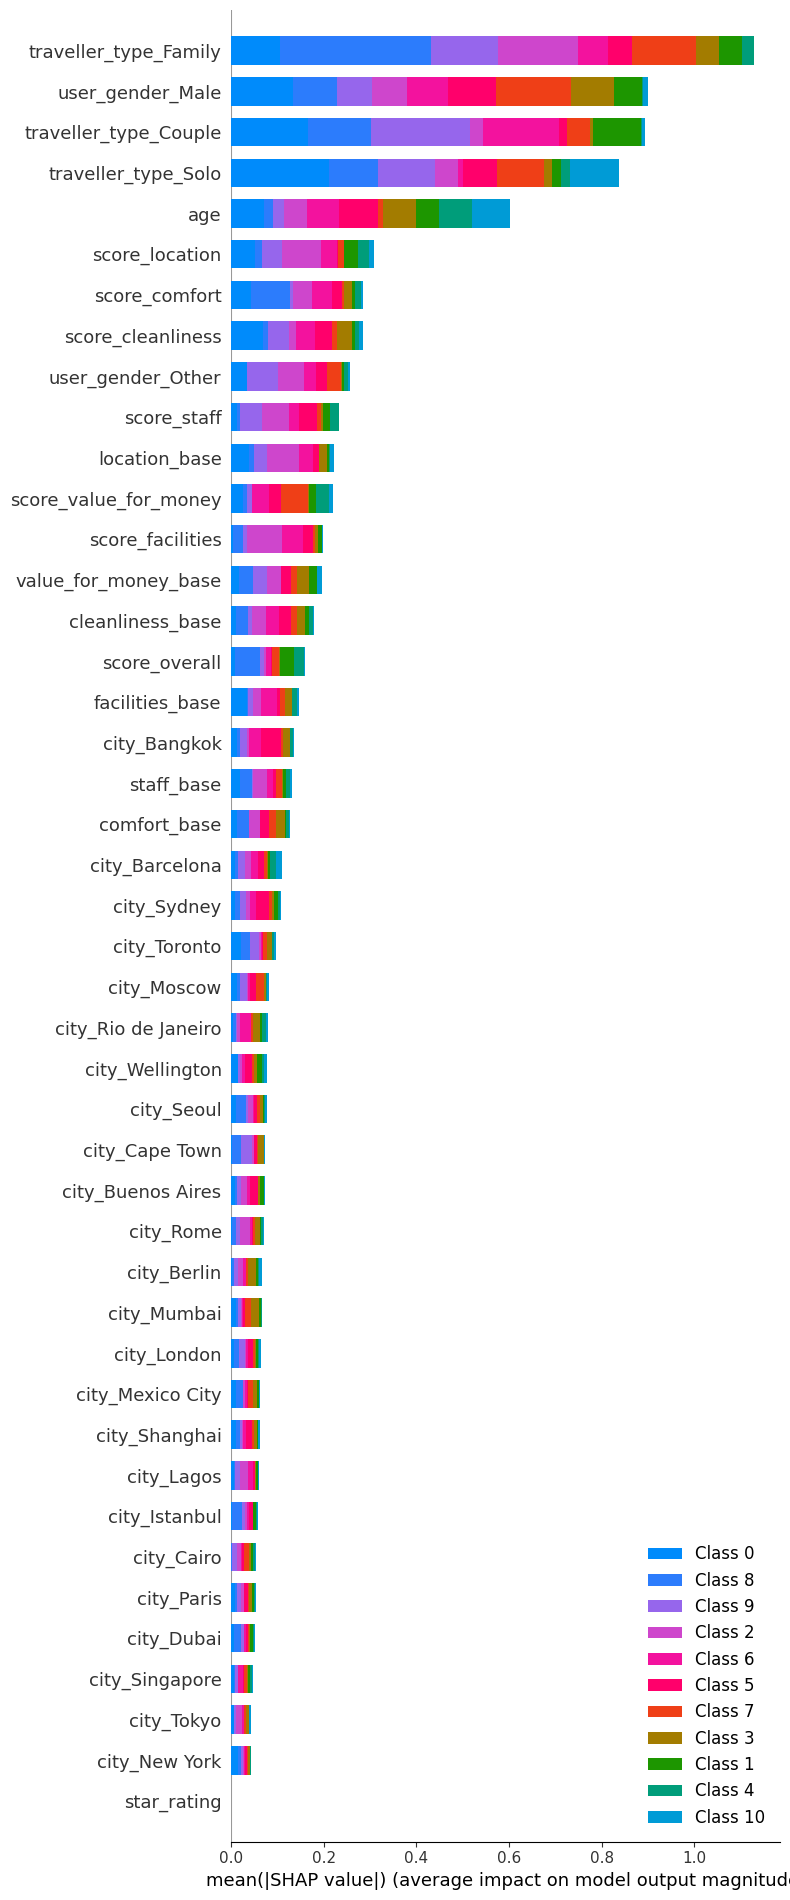

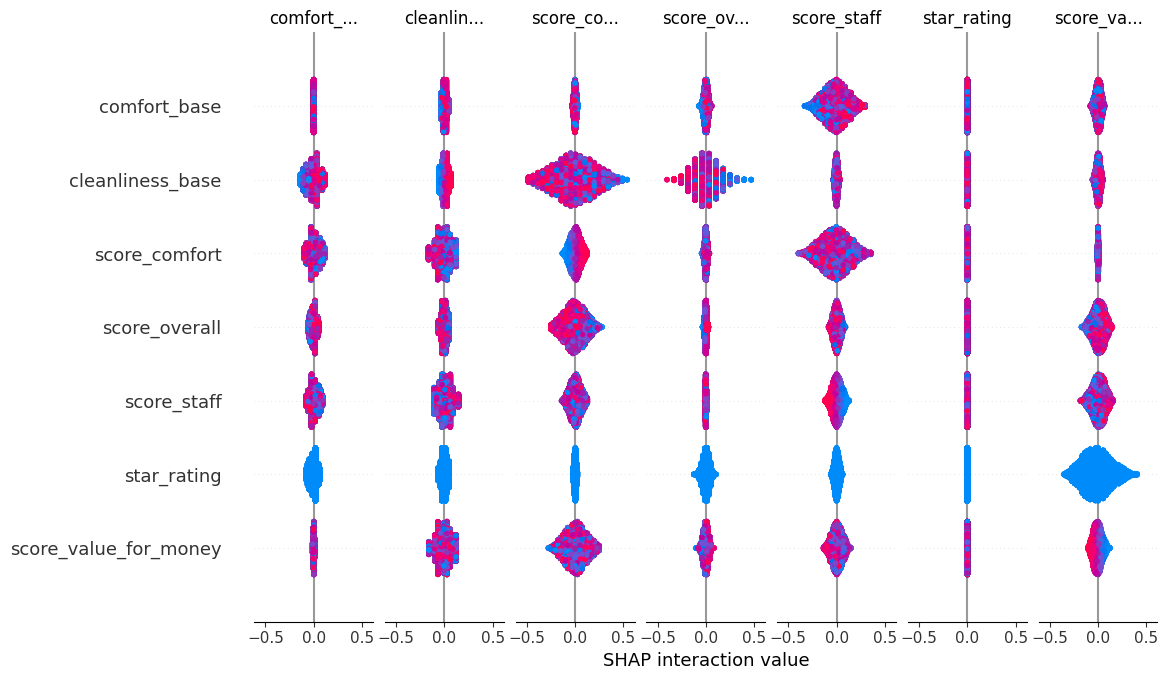

In [32]:
# global explanation
explainer = shap.LinearExplainer(log_model, X_train)

shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]


shap_values = np.array(shap_values, dtype=np.float64)


shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=X_test.shape[1])
shap.summary_plot(shap_values, X_test, show=True)

In [33]:
# shap.initjs()

# # Use only a sample of X_train to make SHAP faster
# X_train_sample = X_train.sample(300, random_state=42)

# # Initialize SHAP LinearExplainer for Logistic Regression
# explainer = shap.LinearExplainer(log_model, X_train_sample)

# # Compute SHAP values
# shap_values = explainer.shap_values(X_test)

# # Handle cases where shap_values is a list (multi-class models)
# if isinstance(shap_values, list):
#     shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]

# # Convert to numpy array safely
# shap_values = np.array(shap_values, dtype=np.float64)

# # Pick one test example (e.g., index 5)
# sample_idx = 5

# # Select that row
# X_sample = X_test.iloc[[sample_idx]]

# # Compute SHAP values for this instance
# shap_values_sample = explainer.shap_values(X_sample)

# # Handle multi-class
# if isinstance(shap_values_sample, list):
#     shap_values_sample = shap_values_sample[1] if len(shap_values_sample) > 1 else shap_values_sample[0]

# # Local force plot for one prediction
# shap.force_plot(
#     explainer.expected_value, 
#     shap_values_sample, 
#     X_sample
# )

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Ensure consistent random state
np.random.seed(42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# ---- Create LIME Explainer ----
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=log_model.classes_.astype(str),
    mode='classification',
    discretize_continuous=True
)

# ---- Pick one instance ----
sample_idx = 39
sample = X_test.iloc[sample_idx]

# Get model prediction for this instance
pred_label = log_model.predict(sample.values.reshape(1, -1))[0]      # e.g. "Western_Europe"
pred_class_idx = np.where(log_model.classes_ == pred_label)[0][0]    # convert to numeric index
pred_class_name = log_model.classes_[pred_class_idx]

print(f"Predicted class: {pred_class_name}")

# ---- Explain ONLY the predicted class ----
exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=log_model.predict_proba, 
    num_features=10,
    labels=[pred_class_idx]   # ✅ use numeric index
)

# ---- Visualize ----
exp.show_in_notebook(show_table=True, labels=[pred_class_idx])

# ---- Text summary ----
print(f"\nLIME Explanation for predicted class '{pred_class_name}':")
for feature, weight in exp.as_list(label=pred_class_idx):
    print(f"{feature}: {weight:.4f}")

Train shape: (40000, 44)
Test shape: (10000, 44)


c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\abdel\fire_env_tf\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abdel\fire_env_tf\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\abdel\fire_env_tf\lib\site-packages\lime\lime_tabular.py:544: FutureW

Predicted class: Western_Europe



LIME Explanation for predicted class 'Western_Europe':
traveller_type_Solo <= 0.00: -0.0693
age > 4.00: 0.0538
city_Barcelona <= 0.00: 0.0306
city_Singapore <= 0.00: -0.0155
city_Toronto <= 0.00: -0.0133
city_Shanghai <= 0.00: 0.0125
city_Moscow <= 0.00: 0.0122
city_Berlin <= 0.00: 0.0122
city_Wellington <= 0.00: 0.0103
city_London <= 0.00: 0.0098


In [36]:
# Encode string labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode for NN output layer
y_categorical = to_categorical(y_encoded)

In [37]:
print("y_encoded shape:", y_encoded.shape)
print("y_categorical shape:", y_categorical.shape)

y_encoded shape: (50000,)
y_categorical shape: (50000, 11)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # number of country groups
])

c:\Users\abdel\fire_env_tf\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
#test model(no change)
# num_features = X_train_scaled.shape[1]
# num_classes = y_train.shape[1]  

# model = Sequential([
#     Dense(128, activation='relu', input_shape=(num_features,)),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(num_classes, activation='softmax')
# ])


In [42]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (40000, 44)
y_train shape: (40000, 11)


In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train,
                    epochs=50, batch_size=32,
                    validation_split=0.2, verbose=1)

y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("=== Neural Network Evaluation ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("\nDetailed Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3195 - loss: 2.0212 - val_accuracy: 0.3354 - val_loss: 1.9646
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3362 - loss: 1.9730 - val_accuracy: 0.3350 - val_loss: 1.9591
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3371 - loss: 1.9646 - val_accuracy: 0.3340 - val_loss: 1.9591
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3370 - loss: 1.9595 - val_accuracy: 0.3351 - val_loss: 1.9553
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3375 - loss: 1.9548 - val_accuracy: 0.3350 - val_loss: 1.9538
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3385 - loss: 1.9504 - val_accuracy: 0.3365 - val_loss: 1.9519
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3389 - loss: 1.9480 - val_accuracy: 0.3383 - val_loss: 1.9458
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3394 - loss: 1.9430 - 

c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdel\fire_en

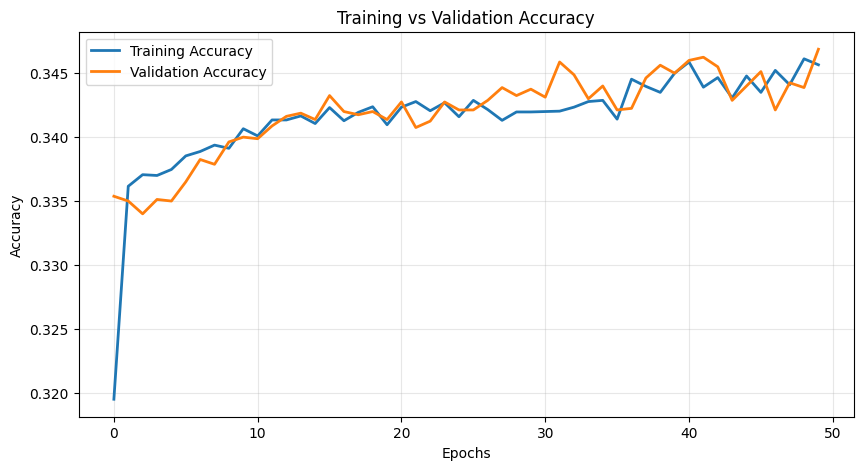

In [44]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [45]:
X_sample = X_test_scaled[:300]

In [46]:
# Define a prediction function that outputs probabilities
def predict_fn(data):
    return model.predict(data, verbose=0)

# Initialize SHAP KernelExplainer
background = shap.sample(X_train_scaled, 100, random_state=42)
explainer = shap.KernelExplainer(predict_fn, background)

In [48]:
# Compute SHAP values for a smaller batch
shap_values = explainer.shap_values(background[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:54<00:00,  5.44s/it]


C:\Users\abdel\AppData\Local\Temp\ipykernel_3692\2589127859.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


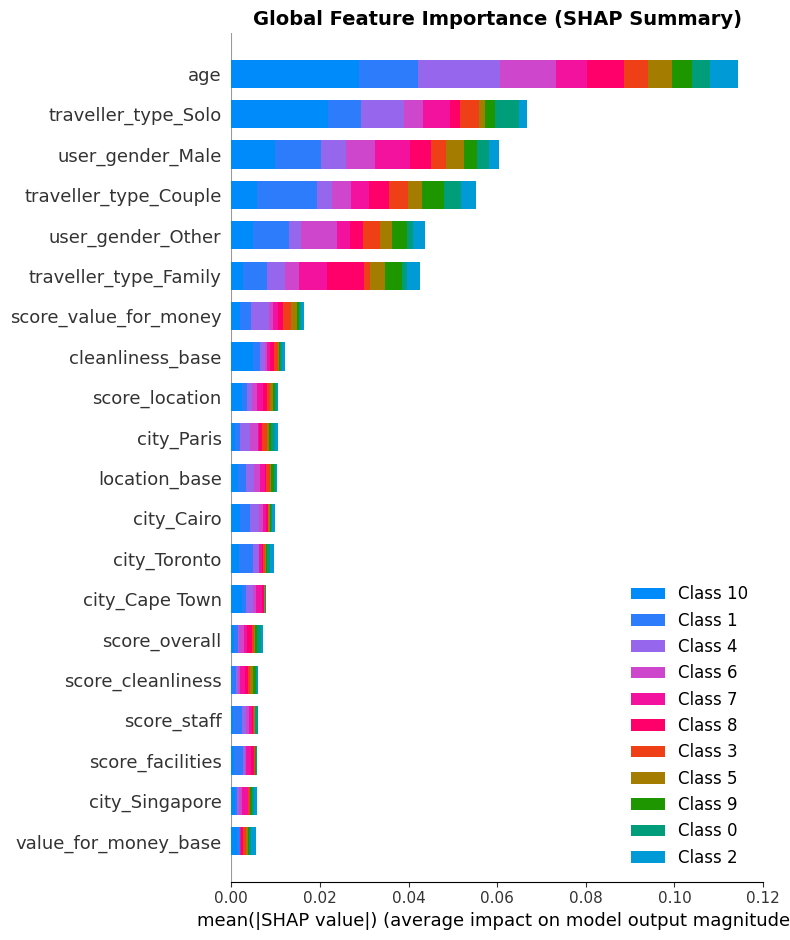

In [49]:
# Create a SHAP summary plot for global feature importance
shap.summary_plot(
    shap_values,
    X_sample[:100],
    feature_names=X.columns,
    plot_type="bar",
    show=False
)

plt.title("Global Feature Importance (SHAP Summary)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [51]:
# shap.summary_plot(
#     shap_values,
#     X_sample[:100],
#     feature_names=X.columns
# )